In [1]:
import cv2
import math
import numpy as np
import mediapipe as mp
from time import time
import matplotlib.pyplot as plt

In [2]:
mp_pose=mp.solutions.pose
pose=mp_pose.Pose(static_image_mode=True,min_detection_confidence=0.5,min_tracking_confidence=0.5,model_complexity=2)
mp_drawing=mp.solutions.drawing_utils

In [3]:
def PoseDetection(i, pose, display=True):
    output_img = i.copy()# Create a copy of the input image.
    
    RGBimage = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)# Convert the image from BGR into RGB format.
    
    res = pose.process(RGBimage)# Perform the Pose Detection.
    
    height, width, _ = i.shape# Retrieve the height and width of the input image.
    
    landmarks = []# Initialize a list to store the detected landmarks.
    
    if res.pose_landmarks:# Check if any landmarks are detected.
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_img, landmark_list=res.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in res.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_img[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(res.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        # Return the output image and the found landmarks.
        return output_img, landmarks

In [4]:
pose_video=mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,model_complexity=1)
video=cv2.VideoCapture(0)
cv2.namedWindow('Pose Detection',cv2.WINDOW_NORMAL)
video.set(3,1200)
video.set(4,960)
time1=0

while video.isOpened():
    ok,frame=video.read()
    
    if not ok:
        break
        
    frame=cv2.flip(frame,1)
    frame_height,frame_width,_ = frame.shape
    frame=cv2.resize(frame,(int(frame_width*(600/frame_height)),640))
    frame,_=PoseDetection(frame,pose_video,display=False)
    time2=time()
    
    if(time2-time1)>0:
        frames_per_second=1.0/(time2-time1)
        cv2.putText(frame,'FPS:{}'.format(int(frames_per_second)),(10,30),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),3)
        
    time1=time2
    cv2.imshow("Pose Detection",frame)
    k=cv2.waitKey(1) &0xff
    
    if(k==27):
        break
        
video.release()
cv2.destroyAllWindows()

In [5]:
def calculateAngle(landmark1,landmark2,landmark3):
    x1,y1,_=landmark1
    x2,y2,_=landmark2
    x3,y3,_=landmark3
    
    angle=math.degrees(math.atan2(y3-y2,x3-x2)- math.atan2(y1-y2,x1-x2))
    
    if angle<0:
        angle+=360
        
    return angle

In [6]:
angle=calculateAngle((558,326,0),(642,333,0),(718,321,0))
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


In [69]:
def PoseClassification(landmarks, output_image, display=False):
  
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0 ,0 ,255)
    
    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    left_heel_angle=calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value])
    
    right_heel_angle=calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value])
    
    right_hip_angle=calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value])
    
    left_hip_angle=calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value])
    
    # Check if the elbows are at the required angle.  
      
    if left_elbow_angle > 50 and left_elbow_angle < 90 or right_elbow_angle > 280 and right_elbow_angle < 320: 
     
    # Check if the shoulders are at the required angle.  
        if right_shoulder_angle > 190 and right_shoulder_angle < 230 or left_shoulder_angle > 320 and left_shoulder_angle < 360:
            
            # Specify the label of the pose that is Cow Face pose.  
            label = 'Cow Face Pose'
            
    # Check if it is the Downward Facing Dog pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if hips are at the required angle.
    if left_hip_angle > 270 and left_hip_angle < 300 or right_hip_angle > 70 and right_hip_angle < 100:
        
        #Chech if heels are at the required angle.
        if left_heel_angle > 300 and left_heel_angle < 330 or right_heel_angle > 35 and right_heel_angle < 55:
            
            #Check if elbows are at the required angle
            if left_elbow_angle > 180 and left_elbow_angle < 210 or right_elbow_angle > 150 and right_elbow_angle < 180:
                # Specify the label of the pose that is Downward Facing Dog pose.
                label = 'Downward Facing Dog Pose'

    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 55:

            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'
            
            
    if right_shoulder_angle > 30 and right_shoulder_angle < 60 or left_shoulder_angle > 20 and left_shoulder_angle< 70:

        # Check if shoulders are at the required angle.
        if right_hip_angle > 180 and right_hip_angle < 210 or left_hip_angle > 140 and left_hip_angle < 180 :

            # Check if one leg is straight.
            if right_knee_angle > 280 and right_knee_angle < 300 or left_knee_angle > 50 and left_knee_angle < 90 :
                # Check if the other leg is bended at the required angle.
                label = 'Bridge Pose'
                    
                    # Specify the label of the pose that is Bridge pose.
    
    
    #Check if elbows are at the required angle               
    if right_elbow_angle > 165 and right_elbow_angle < 195 or left_elbow_angle > 165 and right_elbow_angle < 195:
        
        #Check if knees are at the required angle
        if left_knee_angle > 80  and left_knee_angle < 100 or right_knee_angle > 250 and right_knee_angle < 280:
            
            #Check if hips are at the required angle
            if left_hip_angle > 240 and left_hip_angle < 270 or right_hip_angle > 110 and right_hip_angle < 140:
                
                # Specify the label of the pose that is Cow pose.
                label="Cow Pose"
  
                
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 15),cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,20])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label

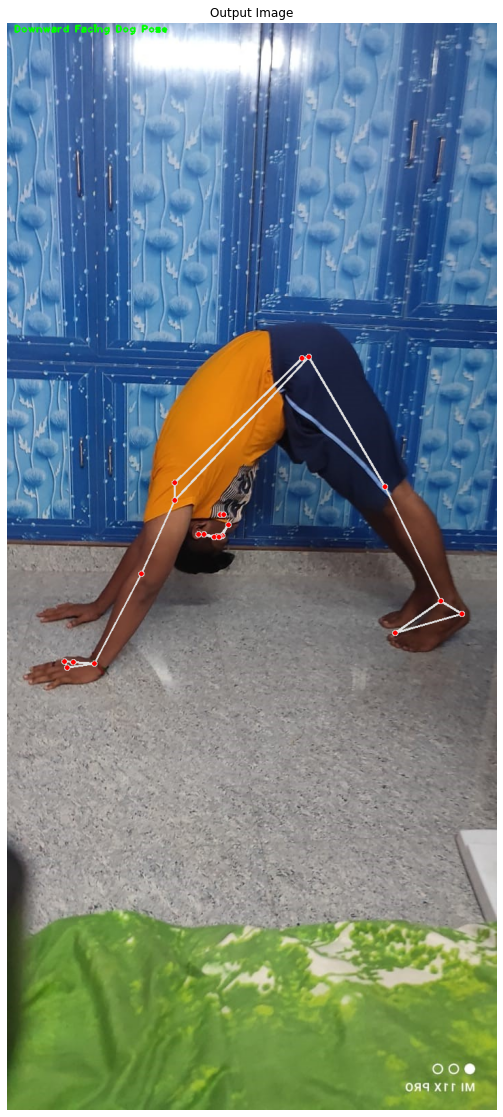

In [33]:
i=cv2.imread("C:\\Users\\freak\\OneDrive\\Desktop\\ppt images\\vid\\dd.jpg")
output_image,landmarks=PoseDetection(i,pose,display=False)
if landmarks:
    PoseClassification(landmarks,output_image,display=True)

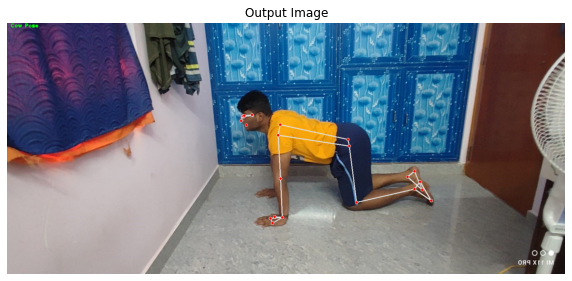

In [34]:
i=cv2.imread("C:\\Users\\freak\\OneDrive\\Desktop\\ppt images\\vid\\cow.jpg")
output_image,landmarks=PoseDetection(i,pose,display=False)
if landmarks:
    PoseClassification(landmarks,output_image,display=True)

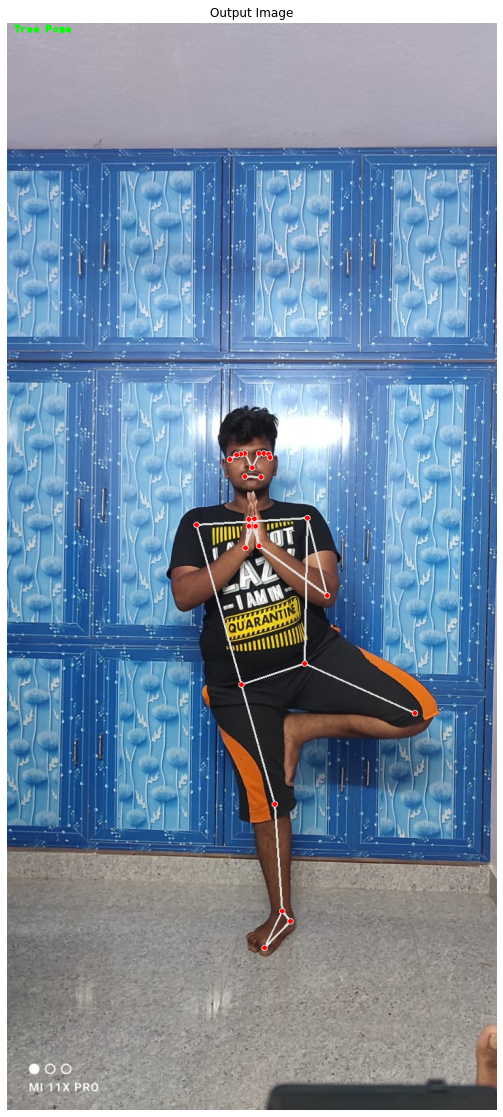

In [35]:
i=cv2.imread("C:\\Users\\freak\\OneDrive\\Desktop\\ppt images\\vid\\tree.jpg")
output_image,landmarks=PoseDetection(i,pose,display=False)
if landmarks:
    PoseClassification(landmarks,output_image,display=True)

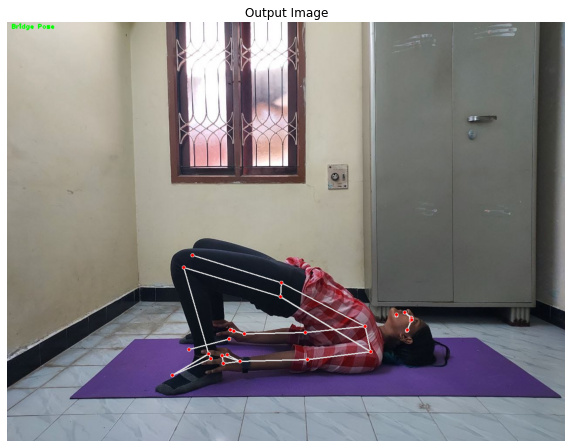

In [32]:
i=cv2.imread("C:\\Users\\freak\\OneDrive\\Desktop\\ppt images\\vid\\bp.jpg")
output_image,landmarks=PoseDetection(i,pose,display=False)
if landmarks:
    PoseClassification(landmarks,output_image,display=True)

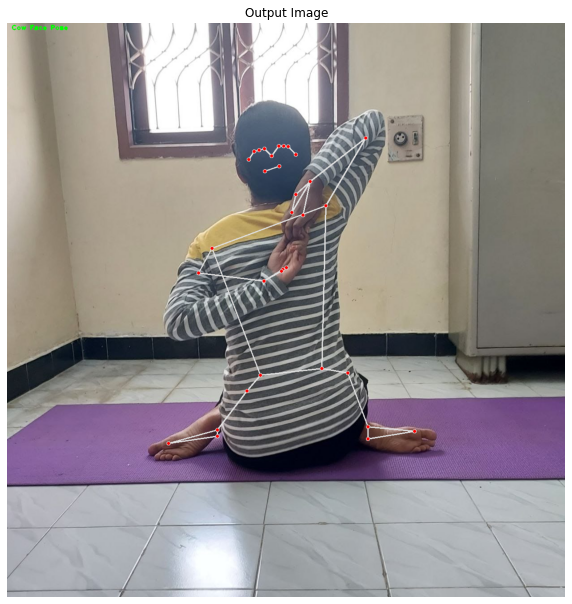

In [70]:
i=cv2.imread("C:\\Users\\freak\\OneDrive\\Desktop\\ppt images\\vid\\cf.jpg")
output_image,landmarks=PoseDetection(i,pose,display=False)
if landmarks:
    PoseClassification(landmarks,output_image,display=True)

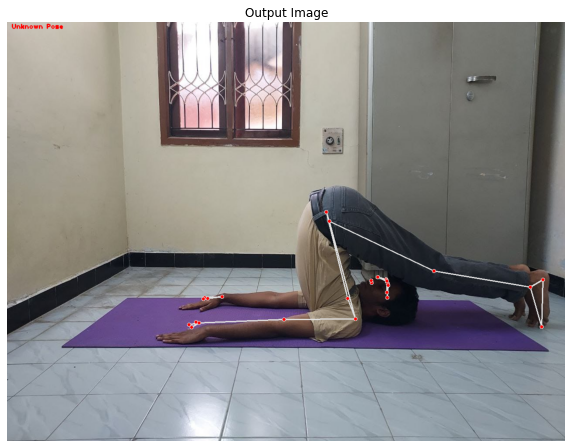

In [71]:
i=cv2.imread("C:\\Users\\freak\\OneDrive\\Desktop\\ppt images\\vid\\unknown_pose.jpg")
output_image,landmarks=PoseDetection(i,pose,display=False)
if landmarks:
    PoseClassification(landmarks,output_image,display=True)

In [14]:
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Initialize a resizable window.
cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, landmarks = PoseDetection(frame, pose_video, display=False)
    
    # Check if the landmarks are detected.
    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = PoseClassification(landmarks, frame, display=False)
    
    # Display the frame.
    cv2.imshow('Pose Classification', frame)
    
    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()